#### 0 Load Packages and Datasets

In [2]:
from pyspark.sql.functions import col
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import Word2Vec
import pyspark.sql.functions as f
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import numpy as np
#clean the stop words:
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import struct
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window
from pyspark.sql.functions import desc

In [3]:
# read data
df = spark.read.load("/FileStore/tables/animals_comments_csv-5aaff.gz", format='csv', header = True, inferSchema = True)

#### 1 Data Exploration and Cleaning

In [5]:
#define a function for data preprocessing process:
def dataPreprocess(data):
  #delete blank comment, null userid, null creators:
  df_drop = data.filter(data.comment.isNotNull())
  df_drop = df_drop.filter(df.userid.isNotNull())
  df_drop = df_drop.filter(df.creator_name.isNotNull())
  #basic info:
  print ('There are ' + str(df_drop.drop_duplicates(subset=['creator_name']).count()) + ' creators in the dataset.')
  print ('There are ' + str(df_drop.drop_duplicates(subset=['userid']).count()) + ' users recorded in the dataset.')
  print ('--------------------------------------------------------------------------------------------------------')
  return df_drop

In [6]:
df_drop = dataPreprocess(df)

There are 3858 creators in the dataset.
There are 2524849 users recorded in the dataset.
--------------------------------------------------------------------------------------------------------

In [7]:
#flags of data subsets:
dog_cat = True
owner = False

In [8]:
#tag the label and return the model dataset:
def tag(data):
  from pyspark.sql.functions import col
  my_cat = data.select('comment').where(col('comment').like("%my cat")).count()
  my_dog = data.select('comment').where(col('comment').like("%my dog")).count()
  cat = data.select('comment').where(col('comment').like("%cat")).count()
  dog = data.select('comment').where(col('comment').like("%dog")).count()
  #basic info of the dataset:
  print ("The basic info of the raw dataset: ")
  print ("There are " + str(my_cat) + " comments containing the cat owner infomation.")
  print ("There are " + str(my_dog) + " comments containing the dog owner infomation.")
  print ("There are " + str(my_cat + my_dog) + " comments containing the cat&dog owner infomation.")
  print ('-----------------------------------------------------------------------------------------')
  
  print ("There are " + str(cat) + " comments containing the cat infomation.")
  print ("There are " + str(dog) + " comments containing the dog infomation.")
  print ("There are " + str(cat + dog) + " comments containing the cat&dog infomation.")
  print ('-----------------------------------------------------------------------------------------')
  #the comments related to the cat and dog:
  cat_n_dog =(data["comment"].like("%dog")|data["comment"].like("%cat"))
  #the comments related to the cat and dog owners:
  owners = (data["comment"].like("%my dog")|data["comment"].like("%my cat"))
  #label the data:
  df_clean = data.withColumn('label',  owners).withColumn('dog_cat',  cat_n_dog)
  cols = ['label']
  for col in cols:
    df_clean = df_clean.withColumn(
      col, 
      f.when(
        f.col(col) == 'True',
        1
      ).when(
        f.col(col) == 'False',
        0
      )
    )
  return df_clean

In [9]:
def subset(data):
  if dog_cat is True:
    df_model = data.filter(data['dog_cat']==True)
  else:
    df_model = data
  return df_model

In [10]:
def target(data):
  if owner is True:
    df_owner = data.filter(data['label']==1)
  return df_owner

In [11]:
df_clean = tag(df_drop)
df_model = subset(df_clean)

The basic info of the raw dataset: 
There are 565 comments containing the cat owner infomation.
There are 852 comments containing the dog owner infomation.
There are 1417 comments containing the cat&dog owner infomation.
-----------------------------------------------------------------------------------------
There are 7119 comments containing the cat infomation.
There are 13829 comments containing the dog infomation.
There are 20948 comments containing the cat&dog infomation.
-----------------------------------------------------------------------------------------

In [12]:
#when the dataset is too large to successful run, we may need take a partial of the data to finish the process:
df_model, drop = df_model.randomSplit([0.2, 0.8],seed = 100)

#### 1 Build the classifier 
In order to train a model against the comments, you can use RegexTokenizer to split each comment into a list of words and then use Word2Vec or other model to convert the list to a word vector. What Word2Vec does is to map each word to a unique fixed-size vector and then transform each document into a vector using the average of all words in the document.

In [14]:
token = True
word = True

In [15]:
def textProcess(data):
  if token:
    regexTokenizer = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'comment', outputCol = 'token')
    data = regexTokenizer.transform(data)
  if word:
    #create an average word vector for each comment:
    word2vec = Word2Vec(vectorSize = 200, minCount = 5, inputCol = 'token', outputCol = 'features')
    model = word2vec.fit(data)
    word_model = model.transform(data)
    word_model = word_model.withColumnRenamed("owners", "label")
  #we can add other natural language processing algorithms in here:
  
  return word_model

In [16]:
word_model = textProcess(df_model)

#### 2 Classify All The Users
We can now apply the cat/dog classifiers to all the other users in the dataset.

In [18]:
def classifier(data):
  #split the model data into train data, cross validation data and test data:
  trainingData, testData = data.randomSplit([0.8, 0.2],seed = 100)
  # Build the model
  lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, family = "binomial")
  # Train model with Training Data
  lrModel = lr.fit(trainingData)
  # Run Results on Training Data
  trainingSummary = lrModel.summary
  print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))
  # Predict on Test Data
  predictions = lrModel.transform(testData)
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
  #cross-validation
  # Create ParamGrid for Cross Validation
  paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())
  # Create 5-fold CrossValidator
  cv = CrossValidator(estimator=lr,estimatorParamMaps=paramGrid,evaluator=evaluator,numFolds=5)
  # Run cross validations
  cvModel = cv.fit(trainingData)
  # this will likely take a fair amount of time because of the amount of models that we're creating and testing
  # Use test set here so we can measure the accuracy of our model on new data
  predictions = cvModel.transform(testData)
  # cvModel uses the best model found from the Cross Validation
  # Evaluate best model
  print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
  return predictions, lrModel, trainingSummary

In [19]:
predictions, lrModel, trainingSummary = classifier(word_model)

Training: Area Under ROC: 0.90805323836
Test: Area Under ROC: 0.902061359148
Test: Area Under ROC: 0.910947358282

In [20]:
#visualization the result
def visual(coef):
  beta = np.sort(coef)
  plt.figure(figsize=(16, 9))
  
  #coefficient
  plt.subplot(2, 2, 1)
  plt.plot(beta)
  plt.ylabel('Beta Coefficients')
  plt.show()
  display()
  
  #roc curve
  plt.subplot(2, 2, 2)
  roc = trainingSummary.roc.toPandas()
  plt.plot(roc['FPR'],roc['TPR'])
  plt.ylabel('False Positive Rate')
  plt.xlabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()
  display()
  
  #roc recall and precision
  plt.subplot(2, 2, 3)
  pr = trainingSummary.pr.toPandas()
  plt.plot(pr['recall'],pr['precision'])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  display()
  
  # Set the model threshold to maximize F-Measure
  #trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
  plt.subplot(2, 2, 4)
  f = trainingSummary.fMeasureByThreshold.toPandas()
  plt.plot(f['threshold'],f['F-Measure'])
  plt.ylabel('F-Measure')
  plt.xlabel('Threshold')
  plt.show()
  display()
  plt.close()

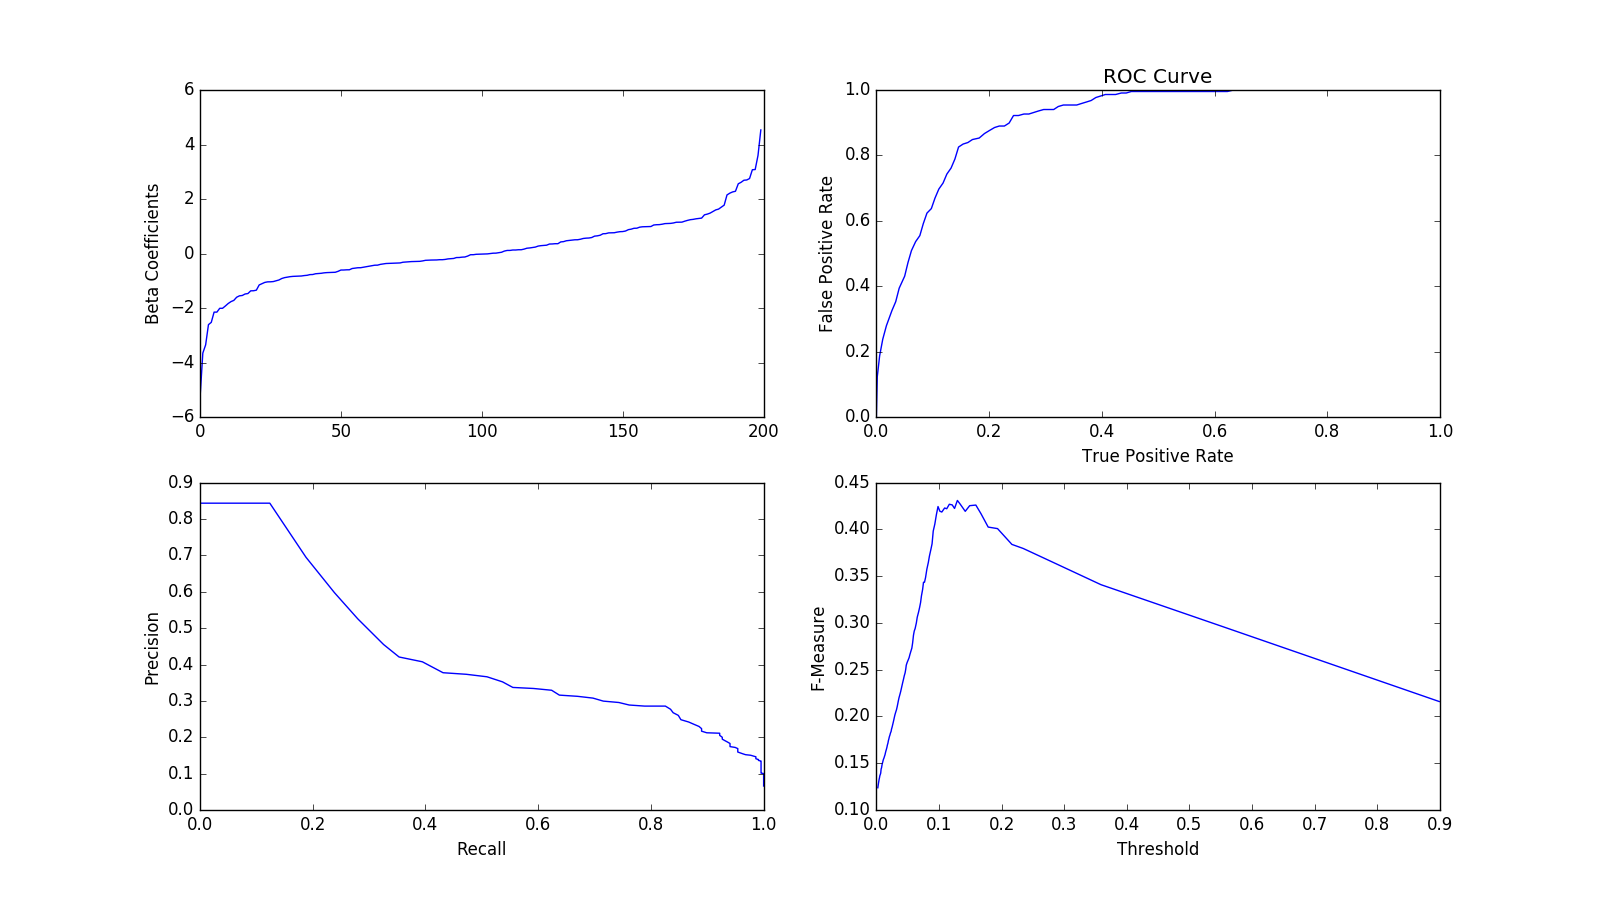

In [21]:
visual(lrModel.coefficients)

#### 3 Get insigts of Users
find out the important topics to the cat/dog owners

In [23]:
owner = True
df_owner = target(df_model)

In [24]:
#custom list of stopwords:
def cleanup_text(record):
    text  = record[2]
    uid   = record[1]
    words = text.split()
    
    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u'arent', u'as', u'at', 
    u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', u'can', u'cant', u'come', u'could', u'couldnt', u'd', u'did',       u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during', u'each', u'few', 'finally', u'for', u'from', u'further', 
    u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here', u'hers', u'herself', u'him', u'himself', u'his', u'how', 
    u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself', u'just', u'll', u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself', 
    u'no', u'nor', u'not', u'now', u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves', u'out', u'over', u'own', 
    u'r', u're', u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such', 
    u't', u'than', u'that', u'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then', u'there', u'these', u'they', u'this', u'those', u'through',         u'to', u'too', u'under', u'until', u'up', u'very', u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while', u'who',           u'whom', u'why', u'will', u'with', u'wont', u'would', u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']
    
    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['im', 'get', 'got', 'one', 'hes', 'shes', 'dog', 'dogs', 'cats', 'cat', 'kitty', 'much', 'really', 'love']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]    
    
    text_out = [re.sub('[^a-zA-Z0-9]','',word) for word in words]                                       # Remove special characters
    text_out = [word.lower() for word in text_out if len(word)>2 and word.lower() not in stopwords]     # Remove stopwords and words under X length
    return text_out

In [25]:
udf_cleantext = udf(cleanup_text , ArrayType(StringType()))
clean_text = df_owner.withColumn("words", udf_cleantext(struct([df_owner[x] for x in df_owner.columns])))

In [26]:
def textAnaly(data):
  #hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
  #featurizedData = hashingTF.transform(clean_text)
 
  # Term Frequency Vectorization  - Option 2 (CountVectorizer)    : 
  cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize = 1000)
  cvmodel = cv.fit(data)
  featurizedData = cvmodel.transform(data)
 
  vocab = cvmodel.vocabulary
  vocab_broadcast = sc.broadcast(vocab)
 
  idf = IDF(inputCol="rawFeatures", outputCol="features")
  idfModel = idf.fit(featurizedData)
  rescaledData = idfModel.transform(featurizedData)
  
  #use LDA here:
  lda = LDA(k=5, seed=123, optimizer="em", featuresCol="features")
  ldamodel = lda.fit(rescaledData)
 
  ldamodel.isDistributed()
  ldamodel.vocabSize()
 
  ldatopics = ldamodel.describeTopics()
  topics_rdd = ldatopics.rdd
  topics_words = topics_rdd.map(lambda row: row['termIndices']).map(lambda idx_list: [vocab[idx] for idx in idx_list]).collect()
  for idx, topic in enumerate(topics_words):
    print ("topic: ", idx)
    print (topic)
    print ("----------")

In [27]:
textAnaly(clean_text)

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-1147780264259309> in <module> () 
 ----> 1 textAnaly ( clean_text ) 

 <command-1147780264259312> in textAnaly (data) 
 5 # Term Frequency Vectorization - Option 2 (CountVectorizer) : 
 6 cv = CountVectorizer ( inputCol = "words" , outputCol = "rawFeatures" , vocabSize = 1000 ) 
 ----> 7 cvmodel = cv . fit ( data ) 
 8 featurizedData = cvmodel . transform ( data ) 
 9 

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 130 return self . copy ( params ) . _fit ( dataset ) 
 131 else : 
 --> 132 return self . _fit ( dataset ) 
 133 else : 
 134 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit (self, dataset) 
 286 
 287 def _fit ( self , dataset ) : 
 --> 288 java_model = self . _fit_java ( dataset ) 
 289 model = self . _create_model ( java_model ) 
 290 return self . _copyValues ( model ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit_java (self, dataset) 
 283 """
 284 self . _transfer_params_to_java ( ) 
 --> 285 return self . _java_obj . fit ( dataset . _jdf ) 
 286 
 287 def _fit ( self , dataset ) : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 61 def deco ( * a , ** kw ) : 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 
 65 s = e . java_exception . toString ( ) 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling o11344.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1590.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1590.0 (TID 1919, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/worker.py", line 262, in main
 process()
 File "/databricks/spark/python/pyspark/worker.py", line 257, in process
 serializer.dump_stream(func(split_index, iterator), outfile)
 File "/databricks/spark/python/pyspark/worker.py", line 183, in <lambda>
 func = lambda _, it: map(mapper, it)
 File "<string>", line 1, in <lambda>
 File "/databricks/spark/python/pyspark/worker.py", line 79, in <lambda>
 return lambda *a: f(*a)
 File "/databricks/spark/python/pyspark/util.py", line 55, in wrapper
 return f(*args, **kwargs)
 File "<command-1147780264259285>", line 21, in cleanup_text
NameError: global name 're' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:317)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:271)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator

#### 4. Identify Creators With Cat And Dog Owners In The Audience
identify video creators with the most viewers that are cat or dog owners.

In [29]:
#in this part, we need to set up a rule to identify the creators are cat and dog friendly or not
#the judgement should based on the label of owners and the comments

In [30]:
df_dog_creator = subset(df_clean)
df_dog_creator = target(df_dog_creator)

In [31]:
#if we only consider the owners in the analysis:
#print the top 20 creators with the most pet owners:
df_dog_creator.groupBy('creator_name').agg(f.sum('label').alias('owners')).sort(desc("owners")).show(20)

+--------------------+------+
 creator_name|owners|
+--------------------+------+
 The Dodo| 156|
Hope For Paws - O...| 110|
 Robin Seplut| 104|
 Brave Wilderness| 98|
 Gohan The Husky| 91|
 Taylor Nicole Dean| 65|
 Vet Ranch| 62|
 Talking Kitty Cat| 62|
Gone to the Snow ...| 55|
 Cole & Marmalade| 49|
Zak Georges Dog T...| 46|
 Brian Barczyk| 38|
 stacyvlogs| 38|
 Paws Channel| 30|
 Funny Pets| 26|
 SlideShow ForFun| 18|
 meow meow| 16|
 The Pet Collective| 15|
 DarkDynastyK9s| 14|
 FunnyClix| 14|
+--------------------+------+
only showing top 20 rows

In [32]:
#or we can also use the percentage as the rule to find out the most popular creators with pet owners:

In [33]:
#print the top 20 creators with the most pet owners:
window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_dog_creator\
.groupBy('creator_name')\
.agg(f.sum('label').alias('SumPeople'))\
.withColumn('total',sum(col('SumPeople')).over(window))\
.withColumn('Percent',col('SumPeople')*100/col('total'))\
.drop(col('total')).sort(desc("Percent")).show(20)

+--------------------+---------+------------------+
 creator_name|SumPeople| Percent|
+--------------------+---------+------------------+
 The Dodo| 156|11.009174311926605|
Hope For Paws - O...| 110| 7.76287932251235|
 Robin Seplut| 104| 7.339449541284404|
 Brave Wilderness| 98| 6.916019760056457|
 Gohan The Husky| 91| 6.422018348623853|
 Taylor Nicole Dean| 65| 4.587155963302752|
 Vet Ranch| 62| 4.375441072688779|
 Talking Kitty Cat| 62| 4.375441072688779|
Gone to the Snow ...| 55| 3.881439661256175|
 Cole & Marmalade| 49|3.4580098800282286|
Zak Georges Dog T...| 46|3.2462949894142556|
 stacyvlogs| 38| 2.681721947776994|
 Brian Barczyk| 38| 2.681721947776994|
 Paws Channel| 30| 2.117148906139732|
 Funny Pets| 26| 1.834862385321101|
 SlideShow ForFun| 18|1.2702893436838392|
 meow meow| 16|1.1291460832745237|
 The Pet Collective| 15| 1.058574453069866|
 DarkDynastyK9s| 14|0.9880028228652082|
 FunnyClix| 14|0.9880028228652082|
+--------------------+---------+------------------+
only showing top 20 rows

#### 5 Analysis and Future work

-> #Process the comments:
  In order to train a model against the comments, I use RegexTokenizer to split each comment into a list of words and then use Word2Vec or other model to convert the list to a word vector. What Word2Vec does is to map each word to a unique fixed-size vector and then transform each document into a vector using the average of all words in the document. Word2Vec is an Estimator which takes sequences of words representing documents and trains a Word2VecModel. The model maps each word to a unique fixed-size vector. The Word2VecModel transforms each document into a vector using the average of all words in the document; this vector can then be used as features for prediction, document similarity calculations, etc.

-> #Classifier:
  In this case, I only tried logistic regression with cross validation to finish the classification. The prediction result is satisfied with over 0.9 AUC. If we would like to compare the effects of other models, we can directly add the classifiers in the function 'classifier'.

-> #Important topics to the owners:
  Tthis part is to find out the important topic top the cat/dog owners.Therefore, we need to analysis the comments of the owners [ Use LDA to Cluster the TF-IDF Matrix]From the topic clustering result we can know that the important topics include:
   a. food; school/training; life or age[died]
   b. the emotional expression maily focuse on funny and interesting (e.g. lol)
   Note that due to the large data scale and memory limitation, the analysis cannot be finished in current version. However, the result can be obtained in another file and I just copy the result in here:
  
    ----------
    ('topic: ', 0)
    [u'like', u'feel', u'people', u'hate', u'school', u'time', u'life', u'day', u'last', u'also']
    ----------
    ('topic: ', 1)
    [u'like', u'know', u'looks', u'please', u'back', u'see', u'want', u'died', u'help', u'video']
    ----------
    ('topic: ', 2)
    [u'like', u'back', u'know', u'house', u'video', u'looks', u'time', u'old', u'lol', u'years']
    ----------
    ('topic: ', 3)
    [u'like', u'pit', u'know', u'training', u'want', u'food', u'even', u'good', u'old', u'looks']
    ----------
    ('topic: ', 4)
    [u'like', u'food', u'time', u'know', u'people', u'make', u'want', u'think', u'even', u'looks']
    ----------

-> #Identify creators:
    I am not sure whether I understand the question. In this part, I just sum up the labels to rank the creators. Based on the ranks (the sum or percentages of the pet owners from the comments), I presented a table with the list of our creators from the raw data. Therefore, the video creators that attract most dog or cat owners can be found.